In [1]:
%load_ext autoreload
%autoreload 2

Illustrates exponential model with tight measurement constraints and PSF

In [348]:
import numpy as np
import torch
from torch import nn
import torch
import time
#from pytorch_unet.unet import UNet  # Run "git clone https://github.com/cweniger/pytorch_unet.git"
import swyft
import wandb
import pylab as plt
from pytorch_lightning.loggers import WandbLogger
from scipy.ndimage import gaussian_filter

import scipy.stats.distributions as dist
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

We assume that the likelihood function can be decomposed as
$$p(\mathbf x | \mathbf z) = \Pi_i p(s_i|z_i)$$
Where the components of $\mathbf z$ are wavelet transforms.

In [349]:
SIGMA = 1e-2
NPIX = 32

In [350]:
def down1d(x):
    # Squeeze to make work with zero and one batch dimensions
    return torch.nn.functional.avg_pool1d(x.unsqueeze(0), 2).squeeze(0)

def down2d(x):
    return torch.nn.functional.avg_pool2d(x.unsqueeze(0), 2).squeeze(0)

def down3d(x):
    return torch.nn.functional.avg_pool3d(x.unsqueeze(0), 2).squeeze(0)

def up1d(x):
    return x.repeat_interleave(2, dim = -1)

def up2d(x):
    return x.repeat_interleave(2, dim = -2).repeat_interleave(2, dim = -1)

def up3d(x):
    return x.repeat_interleave(2, dim = -3).repeat_interleave(2, dim = -2).repeat_interleave(2, dim = -1)

def avg1d(x):
    return up1d(down1d(x))

def avg2d(x):
    return up2d(down2d(x))

def avg3d(x):
    return up3d(down3d(x))

In [351]:
def Phi1d(x):
    """
    Takes 1-dim array x of length 2^L and turns it into 1-dim array of length 2*2^L-1
    [x1, x2, x3, x4, (x1+x2)/2, (x3+x4)/2, (x1+x2+x3+x4)/4] etc
    """
    length = x.shape[-1]
    levels = int(np.log2(length))
    temp = x
    out = [temp]
    for l in range(levels):
        temp = down1d(temp)
        out.append(temp)
    return torch.cat(out, dim=-1)

def PhiT1d(x):
    """
    Transpose of Phi1d
    """
    length = int((x.shape[-1]+1)/2)
    levels = int(np.log2(length))
    tmp = x
    out = tmp[..., :length]
    for l in range(levels, 0, -1):
        tmp = torch.repeat_interleave(tmp[..., length:], 2, dim=-1)/2
        out += tmp[..., :length]
    return out

def Cont1d(x):
    """
    Calculates low-res contrastive vector.
    """
    L = int((x.shape[-1]+1)/2)
    x = torch.repeat_interleave(x[..., L:], 2, dim=-1)
    x = torch.cat([x, x[..., -1:]*0], dim = -1)
    return x

def Phi2d(x):
    """
    Takes 2-dim array x of length 2^L and turns it into 1-dim array of length 2*2^L-1
    [x1, x2, x3, x4, (x1+x2)/2, (x3+x4)/2, (x1+x2+x3+x4)/4] etc
    """
    length = x.shape[-1]
    levels = int(np.log2(length))
    temp = x
    out = [temp.flatten(start_dim=-2)]
    for l in range(levels):
        temp = down2d(temp)
        out.append(temp.flatten(start_dim=-2))
    return torch.cat(out, dim=-1)

def PhiT2d(x, length):
    """
    Transpose of Phi2d
    """
#    length = int((x.shape[-1]+1)/2)
    levels = int(np.log2(length))
    tmp = x
    out = torch.zeros(*x.shape[:-2], length, length, device = x.device)
    for l in range(levels, 0, -1):
        tmp = torch.repeat_interleave(tmp[..., length:], 2, dim=-1)/4
        out += tmp[..., :length]
    return out

In [352]:
idx = torch.tensor([[0, 2, 3], [1, 4, 5]])
x = torch.rand(6)
y = x[idx]
z = torch.empty_like(x)
z[idx] = y

levels = 3
n = 2**levels
idx_block = torch.zeros(1, 1)
for l in range(levels):
    idx_block += 1
    idx_block = idx_block.repeat_interleave(2, dim = -1).repeat_interleave(2, dim = -2)
idx_block

tensor([[3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3.]])

In [374]:
def nested_indices_2dim(levels):
    if levels == 0:
        return torch.tensor([[0]])
    x1 = torch.tensor([[0, 1], [2, 3]])
    x = x1
    for l in range(1, levels):
        x = x.repeat(2, 2) + x1.repeat_interleave(2**l, dim=-2).repeat_interleave(2**l, dim=-1)*4**l
    return x

idx = nested_indices_2dim(5)

x = torch.randn(3, 4, 32, 32)

def PhiT(x):
    return x[..., idx]

def Phi(x):
    z = torch.empty(*x.shape[:-2], idx.shape[0]*idx.shape[1])
    z[..., idx] = x
    return z

def Phi2(x, levels):
    batch_dims = x.shape[:-2]
    x = Phi(x)
    out = [x]
    for _ in range(levels):
        x = x.view(*batch_dims, -1, 4).mean(axis=-1)
        out.append(x)
    return torch.cat(out, dim = -1)

def Phi2(x, levels):
    batch_dims = x.shape[:-2]
    x = Phi(x)
    out = [x]
    for _ in range(levels):
        x = x.view(*batch_dims, -1, 4).mean(axis=-1)
        out.append(x)
    return torch.cat(out, dim = -1)

# Function x_img -> x_flattened = Phi x_img
# Function x_flattened -> Phi.T x_flattened
# Function x_flattened (B, N) -> x_flattened (B, N, C) autoregressive correlated channels

class WaveMe:
    def __init__(self, idx, corr_range = 5):
        self.idx = idx
        self.in_shape = self.idx.shape
        self.out_length = len(idx.flatten())
        self.for_idx = idx.flatten()
        self.inv_idx = torch.empty_like(idx.flatten())
        self.inv_idx[idx.flatten()] = torch.tensor(range(len(self.inv_idx)))
        
        if isinstance(corr_range, int):
            corr_range = torch.arange(-corr_range, 0)
        self.auto_idx = (
            corr_range.unsqueeze(0).repeat(self.out_length, 1)
            + torch.arange(self.out_length).unsqueeze(1).repeat(1, len(corr_range))
        )

    def Phi(self, x):
        """Image -> Phi Image"""
        z = x.flatten(start_dim=-len(self.idx.shape))[..., self.for_idx]
        return z
    
    def PhiT(self, z):
        x = z[..., self.inv_idx].view(*z.shape[:-1], *self.idx.shape)
        return x
    
    def Autoregressive(self, z):
        return z[..., self.auto_idx]*(self.auto_idx >= 0)

wm = WaveMe(nested_indices_2dim(5), corr_range = 5)
wm.in_shape

torch.Size([32, 32])

### Generative model

In [375]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = NPIX, sigma = SIGMA, bounds_theta = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*sigma

    def get_pk_fn(self):
#        return lambda k: 1e5*(k/0.5+1)**-3
        return lambda k: k*0 + 2  # pixel std is 1

    def sample_delta(self, pk_fn):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
            return self.powersampler.sample(pk_fn)
            
    def build(self, graph):
        pk_fn = graph.node("pk_fn", self.get_pk_fn)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        rho = graph.node("rho", lambda delta: torch.tensor(gaussian_filter(np.exp(delta*0.2), 1)), delta)
        x = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*self.sigma, rho)

In [376]:
class Network_delta_x(swyft.SwyftModule):
    def __init__(self, N = NPIX):
        super().__init__()
        self.learning_rate = 1e-3
        self.N = N
        L = lambda x: x*0
        self.Phi = wm.Phi
        self.PhiT = wm.PhiT
        self.lre = swyft.lightning.estimators.LogRatioEstimator_Gaussian_Autoregressive_Egmond(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, minstd = 1e-5, momentum=0.02, shape = (NPIX, NPIX))
        self.unet = UNet(1, 1, hidden_channels = 16, shallow=True)
        self.norm1 = torch.nn.LazyBatchNorm2d(momentum = 0.01, affine = False)
        self.norm = swyft.networks.OnlineStandardizingLayer((N, N))
    
    def embed(self, x):
        # Input normalization apparently degrades performance, even for small momentum settings.
#        x = self.norm1(x.unsqueeze(1)).squeeze(1)
        x = self.norm(x)
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x*0
        x = x.view(-1, self.N, self.N)
        return x

    def forward(self, A, B):
        N = self.N
        try:
            xA = self.embed(A['x'])
            deltaB = B['delta']
            result1 = self.lre(xA, deltaB)
        except KeyError:
            result1 = None
        
        return result1

In [377]:
def get_samples(n_sims = 3000, bounds = None):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds, sigma = SIGMA)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    return sim, samples

def train_delta_x(samples, max_epochs = 5, logger = None):
    dm = swyft.SwyftDataModule(samples, batch_size = 64)
    net = Network_delta_x()
    trainer = swyft.SwyftTrainer(accelerator = DEVICE, max_epochs = max_epochs, logger = logger)
    trainer.fit(net, dm)
    return trainer, net

def infer_delta_x(sample0, sim, trainer, net, n_draws = 10, gamma = 0.1, steps = 1000, logger = None):
    GAMMA = gamma
    x = sample0['x']
    d = sample0['delta']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    x0s = []
    for _ in tqdm(range(n_draws)):
        pk = sim.sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        x0s.append(x0)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = steps, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    x0s = torch.stack(x0s)
    
    bounds = [(x0s[i].view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)

    net.float()
    
    v = 15
    fig = plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    #res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    print(x.min(), x.max(), bounds[0].min(), bounds[0].max())
    res = [d - bounds[i] for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    wandb.log({"img1": wandb.Image(fig)})

    fig = plt.figure(figsize = (5, 5))
    x = sample0['delta'].flatten()  # Ground truth
    y = bounds.reshape(-1, NPIX**2)  # Posterior samples
    ym = y.mean(axis=0)
#    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    wandb.log({"img2": wandb.Image(fig)})
    
    fig = plt.figure(figsize = (5, 5))
    x = sample0['delta'].flatten()  # Ground truth
    y = bounds.reshape(-1, NPIX**2)  # Posterior samples
#    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ys)
    ys_exp = SIGMA/0.2/np.exp(x*0.2)
    plt.scatter(x, ys_exp)
    wandb.log({"img2b": wandb.Image(fig)})

    fig = plt.figure(figsize = (5, 5))
    diff = (ym-x).flatten()
    plt.hist(diff, bins = 30)
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)
    print("Mean posterior std per pixel:", ys.mean())
    wandb.log({"img3": wandb.Image(fig)})

    fig = plt.figure(figsize = (5, 5))
    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = sim.sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    wandb.log({"img4": wandb.Image(fig)})

    return bounds

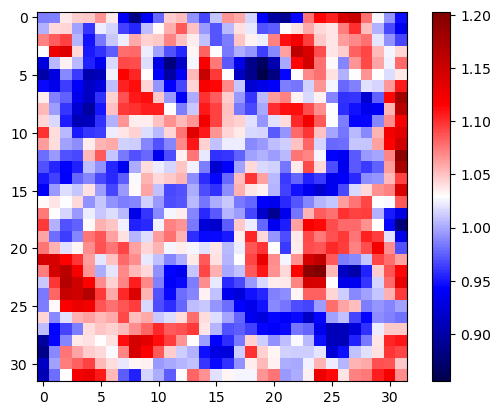

0.059869118


In [378]:
sim = SimulatorBlob(Npix = NPIX, sigma = SIGMA, bounds = None)
sample0 = sim.sample()
del sample0['pk_fn']
x0 = sample0['x']
plt.imshow(x0, cmap = 'seismic')#, vmin = - 20, vmax = 20)
plt.colorbar()
plt.show()
print(x0.std())

In [ ]:
bounds_delta_x = None

for i, GAMMA in enumerate([1e-1, 1e-1, 1e-1, 1]):
    wandb.init(reinit = True, project = 'VT3c', group = 'experiment_1', name = 'round%i'%i)
    wandb_logger = WandbLogger(log_model='all')
    sim, samples = get_samples(n_sims = 1000, bounds = bounds_delta_x)
    trained_delta_x = train_delta_x(samples, max_epochs = 100, logger = wandb_logger)
    bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 100, gamma = GAMMA, steps = 300, logger = wandb_logger)
    wandb.finish()